In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# ! pip list

In [ ]:
# ! pip install imageio opencv-python

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [52]:
path = "./drive/MyDrive/Project/Lip_reading/raw_data/"

In [53]:
test_path = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"

## Video Loading Test

In [54]:
! ls drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/

bbaf2n.mpg  brwa5a.mpg	lgif3a.mpg  pbav3s.mpg	prwj8n.mpg  sgbp7a.mpg
bbaf3s.mpg  brwg6n.mpg	lgifzn.mpg  pbav4p.mpg	prwj9s.mpg  sgbv8n.mpg
bbaf4p.mpg  brwg7s.mpg	lgil4n.mpg  pbav5a.mpg	prwk1a.mpg  sgbv9s.mpg
bbaf5a.mpg  brwg8p.mpg	lgil5s.mpg  pbbc4n.mpg	prwkzp.mpg  sgbx1a.mpg
bbal6n.mpg  brwg9a.mpg	lgil6p.mpg  pbbc5s.mpg	prwq2n.mpg  sgbxzp.mpg
bbal7s.mpg  brwn1s.mpg	lgil7a.mpg  pbbc6p.mpg	prwq3s.mpg  sgib8n.mpg
bbal8p.mpg  brwn2p.mpg	lgir8n.mpg  pbbc7a.mpg	prwq4p.mpg  sgib9s.mpg
bbal9a.mpg  brwn3a.mpg	lgir9s.mpg  pbbi8n.mpg	prwq5a.mpg  sgic1a.mpg
bbas1s.mpg  brwnzn.mpg	lgis1a.mpg  pbbi9s.mpg	prwx6n.mpg  sgiczp.mpg
bbas2p.mpg  brwt4n.mpg	lgiszp.mpg  pbbj1a.mpg	prwx7s.mpg  sgii2n.mpg
bbas3a.mpg  brwt5s.mpg	lgiz2n.mpg  pbbjzp.mpg	prwx8p.mpg  sgii3s.mpg
bbaszn.mpg  brwt6p.mpg	lgiz3s.mpg  pbbp2n.mpg	prwx9a.mpg  sgii4p.mpg
bbaz4n.mpg  brwt7a.mpg	lgiz4p.mpg  pbbp3s.mpg	pwad2n.mpg  sgii5a.mpg
bbaz5s.mpg  bwaa1s.mpg	lgiz5a.mpg  pbbp4p.mpg	pwad3s.mpg  sgio6n.mpg
bbaz6p.mpg  bwaa2p.mpg	lgwa1a.mpg 

In [105]:
# Get the video
cap = cv2.VideoCapture(test_path)


array([[[ 88,  65,  56],
        [ 89,  66,  57],
        [106,  64,  58],
        ...,
        [ 55,  30,  21],
        [ 54,  29,  22],
        [ 54,  29,  22]],

       [[212, 189, 180],
        [212, 189, 180],
        [231, 189, 183],
        ...,
        [118,  93,  84],
        [117,  92,  85],
        [117,  92,  85]],

       [[240, 216, 109],
        [241, 217, 110],
        [255, 217, 110],
        ...,
        [129, 111,  40],
        [127, 109,  39],
        [127, 109,  39]],

       ...,

       [[151, 122,  19],
        [151, 122,  19],
        [160, 120,  22],
        ...,
        [102,  83,   4],
        [101,  81,   5],
        [101,  81,   5]],

       [[150, 122,  17],
        [151, 123,  18],
        [160, 121,  20],
        ...,
        [101,  82,   3],
        [101,  81,   5],
        [100,  80,   4]],

       [[150, 122,  17],
        [151, 123,  18],
        [159, 120,  19],
        ...,
        [101,  82,   3],
        [100,  80,   4],
        [100,  80,   4]]], dtype=uint8)
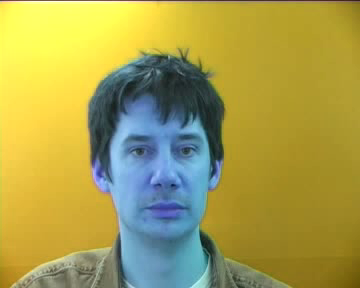

In [106]:
# Get 1 frame with each iteration
ret, frame = cap.read()
# Display the frame
frame


In [107]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

array([[146, 146, 147, ..., 121, 120, 117],
       [146, 146, 147, ..., 121, 117, 116],
       [146, 146, 145, ..., 118, 118, 118],
       ...,
       [137, 137, 137, ..., 112, 111, 111],
       [137, 137, 137, ..., 111, 110, 110],
       [137, 137, 137, ..., 111, 110, 110]], dtype=uint8)
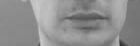

In [109]:
gray[190:236,80:220]

In [98]:
gray = tf.image.rgb_to_grayscale(frame)

In [110]:
# Release the video
cap.release()

## Video Loading Function

In [39]:
def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, convert it to grayscale, crop it to the face,
    normalize it with z-score normalization, and return a numpy array of the frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      # Get one frame as a numpy array
      ret, frame = cap.read()
      # Grayscale conversion
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # => Returns 2D image
      gray = tf.image.rgb_to_grayscale(frame) # => Returns 3D tensor
      # Add the frame to the list
      frames.append(gray[190:236, 80:220, :])
    # Release the video
    cap.release()

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std


In [42]:
frames_test = load_video(test_path)

In [44]:
type(frames_test)

tensorflow.python.framework.ops.EagerTensor

## Char Encoding

In [23]:
# Vocabulary to encode
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [24]:
# Char to num converter
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Num to char converter
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [25]:
# Conversion test
char_to_num(['g', 'a', 'b', 'e'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 1, 2, 5])>

In [26]:
# Retrieving chars test
num_to_char([7, 1, 2, 5])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'g', b'a', b'b', b'e'], dtype=object)>

## Alignments Loading Test

In [29]:
! ls drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/

bbaf2n.align  bwbg8n.align  lrik4p.align  pgwe6n.align	sbwo1s.align
bbaf3s.align  bwbg9s.align  lrik5a.align  pgwe7s.align	sbwo2p.align
bbaf4p.align  bwbh1a.align  lriq6n.align  pgwe8p.align	sbwo3a.align
bbaf5a.align  bwbhzp.align  lriq7s.align  pgwe9a.align	sbwozn.align
bbal6n.align  bwbn2n.align  lriq8p.align  pgwl1s.align	sbwu4n.align
bbal7s.align  bwbn3s.align  lriq9a.align  pgwl2p.align	sbwu5s.align
bbal8p.align  bwbn4p.align  lriy1s.align  pgwl3a.align	sbwu6p.align
bbal9a.align  bwbn5a.align  lriy2p.align  pgwlzn.align	sbwu7a.align
bbas1s.align  bwbt6n.align  lriy3a.align  pgwr4n.align	sgac2n.align
bbas2p.align  bwbt7s.align  lriyzn.align  pgwr5s.align	sgac3s.align
bbas3a.align  bwbt8p.align  lrwf1s.align  pgwr6p.align	sgac4p.align
bbaszn.align  bwbt9a.align  lrwf2p.align  pgwr7a.align	sgac5a.align
bbaz4n.align  bwig1s.align  lrwf3a.align  pgwy8n.align	sgai6n.align
bbaz5s.align  bwig2p.align  lrwfzn.align  pgwy9s.align	sgai7s.align
bbaz6p.align  bwig3a.align  lrwl4n.align  pgwz1a

In [51]:
al_path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/bbaf2n.align"

In [6]:
# Open align file
with open(al_path + "/bbal6n.align", "r") as f:
    lines = f.readlines()

In [7]:
lines

['0 16000 sil\n',
 '16000 21250 bin\n',
 '21250 26750 blue\n',
 '26750 27750 at\n',
 '27750 31500 l\n',
 '31500 39250 six\n',
 '39250 45250 now\n',
 '45250 74500 sil\n']

In [27]:
# Tokienize alignments
tokens = []
for line in lines:
    line = line.split()
    # Ignore silence tokens
    if line[2] != "sil":
        tokens = [*tokens, ' ', line[2]]

tokens

[' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'l', ' ', 'six', ' ', 'now']

## Alignments Loading Function

In [50]:
def load_alignments(path: str) -> tf.Tensor:
  '''
  Load alignments from a path, tokenize them,
  and return the encoded characters as a 1D tensor.
  '''
  # Open align file
  with open(path, "r") as f:
    lines = f.readlines()

  # Tokienize alignments
  tokens = []
  for line in lines:
      line = line.split()
      # Ignore silence tokens
      if line[2] != "sil":
          tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

### Test

In [46]:
x = load_alignments(al_path)

In [47]:
x

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [48]:
num_to_char(x)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'f', b' ', b't', b'w', b'o', b' ', b'n', b'o', b'w'],
      dtype=object)>

## Load Data Function

In [66]:
def load_data(file_name: str):
  '''
  Take a path, load the video and corresponding alignments,
  and return two tensors, one for the processed frames,
  one for the encoded tokens.
  '''
  # Get file name from path
  # file_name = al_path.split('/')[-1].split('.')[0]

  # Path of gdrive
  p = "./drive/MyDrive/Project/Lip_reading/raw_data"
  # Path outside of gdrive
  #p = "raw_data"

  # Get path from file name
  video_path = os.path.join(p, 'videos', 's1',f'{file_name}.mpg')
  alignment_path = os.path.join(p,'alignments','s1',f'{file_name}.align')

  # Load data
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

### Load Test

In [67]:
f, a = load_data("bbaf2n")

In [69]:
a

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

# Pipeline